In [16]:
import ast
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

In [17]:
LOG_FILES = {
    "LoRA": "llora_results.txt",
    "Hybrid": "hybrid.txt"
}

Now need to extract training results from the txt file, as very messy 

In [18]:
def safe_smooth(y, window=9, poly=2):
    return savgol_filter(
        y,
        window_length=min(len(y) if len(y) % 2 == 1 else len(y) - 1, window),
        polyorder=poly
    ) if len(y) > 5 else y

def avg(lst):
    return round(sum(lst) / len(lst), 5) if lst else None



In [19]:
def parse_log(file_path):
    train_accs, train_losses, train_epochs = [], [], []
    eval_accs, eval_losses, eval_entropies, eval_epochs = [], [], [], []

    pattern = re.compile(r"\{.*\}")

    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            match = pattern.search(line)
            if not match:
                continue
            try:
                metrics = ast.literal_eval(match.group())

                # Evaluation metrics
                if "eval_mean_token_accuracy" in metrics or "eval_loss" in metrics:
                    if "eval_mean_token_accuracy" in metrics:
                        eval_accs.append(metrics["eval_mean_token_accuracy"])
                    if "eval_loss" in metrics:
                        eval_losses.append(metrics["eval_loss"])
                    if "eval_entropy" in metrics:
                        eval_entropies.append(metrics["eval_entropy"])
                    if "epoch" in metrics:
                        eval_epochs.append(metrics["epoch"])

                # Training metrics
                elif "mean_token_accuracy" in metrics and "loss" in metrics:
                    train_accs.append(metrics["mean_token_accuracy"])
                    train_losses.append(metrics["loss"])
                    if "epoch" in metrics:
                        train_epochs.append(metrics["epoch"])

            except Exception as e:
                print(f"Error parsing line in {file_path}: {e}")
                continue

    return {
        "train_accs": train_accs,
        "train_losses": train_losses,
        "train_epochs": train_epochs,
        "eval_accs": eval_accs,
        "eval_losses": eval_losses,
        "eval_entropies": eval_entropies,
        "eval_epochs": eval_epochs,
    }

# === PARSE BOTH LOGS ===
results = {name: parse_log(path) for name, path in LOG_FILES.items()}

Now give final training metrics for purley llora training and a hybrid method that uses weight freezing with llora to target and modify more weights during training.

In [20]:
for name, r in results.items():
    print(f"\n=== {name.upper()} METRICS ===")
    print(f"Avg Train Accuracy: {avg(r['train_accs'])}")
    print(f"Avg Train Loss:     {avg(r['train_losses'])}")
    print(
    f"Epoch Range:        {min(r['eval_epochs'])} – {max(r['eval_epochs'])}"
    if r['eval_epochs'] else "No evaluation data"
)

    print(f"\nAvg Eval Accuracy:  {avg(r['eval_accs'])}")
    print(f"Avg Eval Loss:      {avg(r['eval_losses'])}")
    print(f"Avg Eval Entropy:   {avg(r['eval_entropies'])}")
    print(
    f"Epoch Range:        {min(r['train_epochs'])} – {max(r['train_epochs'])}"
    if r['train_epochs'] else "No training data"
)


=== LORA METRICS ===
Avg Train Accuracy: 0.62834
Avg Train Loss:     1.80502
Epoch Range:        0.02 – 1.99

Avg Eval Accuracy:  0.59816
Avg Eval Loss:      2.12283
Avg Eval Entropy:   2.03546
Epoch Range:        0.0 – 1.96

=== HYBRID METRICS ===
Avg Train Accuracy: 0.75371
Avg Train Loss:     1.1457
Epoch Range:        0.1 – 1.76

Avg Eval Accuracy:  0.70614
Avg Eval Loss:      1.59432
Avg Eval Entropy:   1.44726
Epoch Range:        0.0 – 1.86


Clear improvment using the hybrid method though a little more unstable 

Final plot for comparitive analysis of training and test loss over all epoches

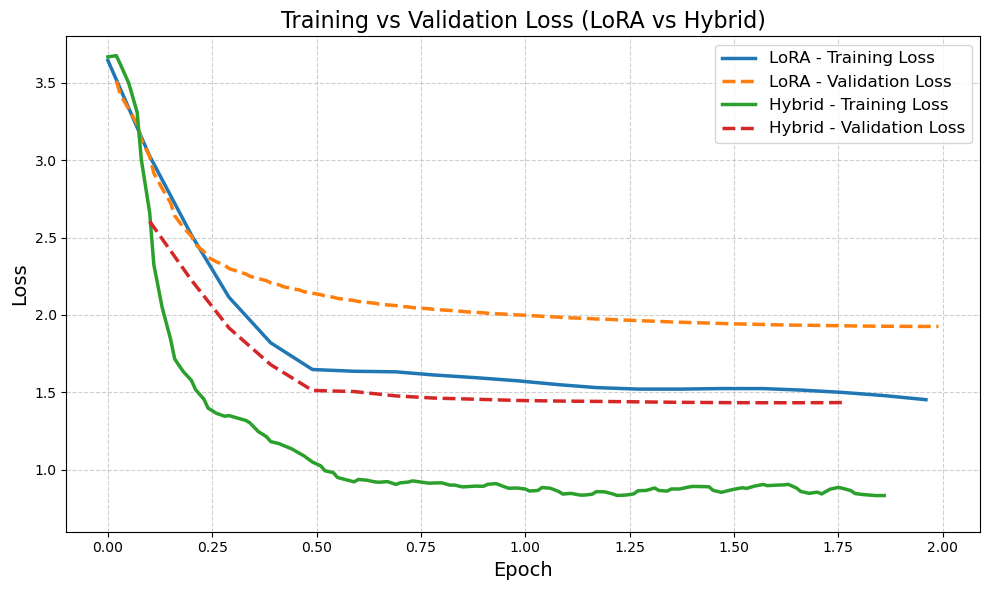

In [21]:
plt.figure(figsize=(10, 6))

for name, r in results.items():
    train_epochs_np = np.array(r["train_epochs"])
    train_losses_np = np.array(r["train_losses"])
    eval_epochs_np = np.array(r["eval_epochs"])
    eval_losses_np = np.array(r["eval_losses"])

    # Smooth curves
    train_losses_smooth = safe_smooth(train_losses_np)
    eval_losses_smooth = safe_smooth(eval_losses_np)

    # Plot
    plt.plot(
        train_epochs_np[:len(train_losses_smooth)],
        train_losses_smooth,
        label=f"{name} - Training Loss",
        linewidth=2.5
    )
    plt.plot(
        eval_epochs_np[:len(eval_losses_smooth)],
        eval_losses_smooth,
        label=f"{name} - Validation Loss",
        linewidth=2.5,
        linestyle="--"
    )

# Formatting
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Training vs Validation Loss (LoRA vs Hybrid)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.ylim(0.6, 3.8)
plt.tight_layout()
plt.show()